# Forecast IC-capacity over the next 5 years

In [1]:
# Importeren van de benodigde libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from os import path, getcwd

## Inladen van de benodigde datasets

In [2]:
# Dataset path
root_dir = path.join(getcwd(), 'Datasets')

# Inlezen benodigde CSV-bestanden
df_per_dag = pd.read_csv(path.join(root_dir, "data_per_dag.csv"))
df_per_leeftijd = pd.read_csv(path.join(root_dir, "data_per_leeftijd.csv"))

# Eerste week van df_per_dag halen, zodat de tijdranges in beide datasets overeen komen.
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
df_per_dag = df_per_dag.loc[(df_per_dag["Date_adj"] >= "2020-04-01") & (df_per_dag["Date_adj"] < "2021-11-01")]

df_per_dag.head(5)

,Aanwezig op IC verdacht of bewezen Corona,Aanwezig op verpleegafdeling verdacht of bewezen Corona,Opname IC Corona,Opname IC verdacht,Opname IC totaal,Opname verpleegafdeling Corona,Opname verpleegafdeling verdacht,Opname verpleegafdeling totaal,Date_adj,Infection
1,231,1175,23,0,23,130,3,133,2021-10-31,8823
2,222,1119,13,0,13,139,2,141,2021-10-30,8504
3,234,1101,27,0,27,157,2,159,2021-10-29,8440
4,220,1026,23,0,23,136,6,142,2021-10-28,7946
5,216,965,21,0,21,145,5,150,2021-10-27,8499


In [3]:
# Set index dataset

df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
Index_df_per_dag = df_per_dag[["Aanwezig op IC verdacht of bewezen Corona", "Date_adj"]]
Index_df_per_dag.set_index(["Date_adj"], inplace=True)

Index_df_per_dag

,Aanwezig op IC verdacht of bewezen Corona
Date_adj,
2021-10-31,231
2021-10-30,222
2021-10-29,234
2021-10-28,220
2021-10-27,216
...,...
2020-04-05,1312
2020-04-04,1285
2020-04-03,1279


In [4]:
# Replace daily numbers with montly averages
#Index_df_per_dag["IC-capaciteit_log"] = np.log(Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"])
Index_df_per_dag = Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"].resample("MS").max()

Index_df_per_dag


Date_adj
2020-04-01    1321
2020-05-01     680
2020-06-01     157
2020-07-01      43
2020-08-01      55
2020-09-01     179
2020-10-01     626
2020-11-01     661
2020-12-01     740
2021-01-01     751
2021-02-01     662
2021-03-01     710
2021-04-01     856
2021-05-01     853
2021-06-01     445
2021-07-01     187
2021-08-01     231
2021-09-01     225
2021-10-01     234
Freq: MS, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

## Verdelen van de dataset in een train- en testset.

In [5]:
train = Index_df_per_dag[:14]
test = Index_df_per_dag[14:19]
test

Date_adj
2021-06-01    445
2021-07-01    187
2021-08-01    231
2021-09-01    225
2021-10-01    234
Freq: MS, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

# Building the ARIMA-model
1. Predict p, q and d
2. Build model
3. Visualize model
4. Evaluate model

In [21]:
# Get P-value
from statsmodels.tsa.stattools import adfuller
diff_1 = Index_df_per_dag.diff().dropna()
print("p-value:", adfuller(Index_df_per_dag)[1])

p-value: 0.03725516334292829


Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **0** dient te krijgen.

In [22]:
# Predict p, q and d
import itertools
from sklearn.metrics import mean_squared_error

p=range(0,8)
q=range(0,8)
d=range(0,1)

pdq_combination = list(itertools.product(p,d,q))

rmse=[]
order1=[]

for pdq in pdq_combination:
    try:
        model= ARIMA(train, order=pdq).fit()
        pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))
        error = np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)

    except:
        continue


results = pd.DataFrame(index=order1, data=rmse, columns= ["RMSE"])

results.to_excel("Arima_results.xlsx")

In [23]:
# Build model
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

model = ARIMA(train, order=(4,0,3)).fit()

pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))

Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

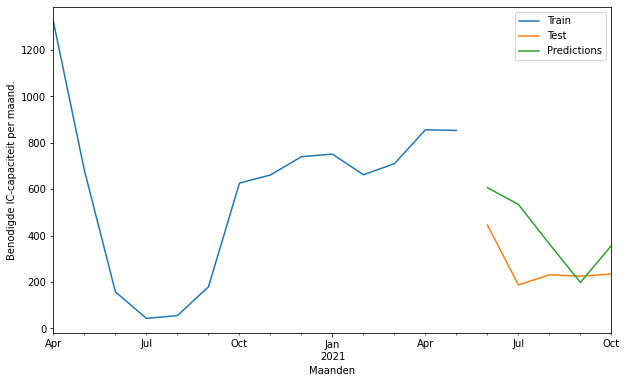

In [24]:
# Plot train, test and predicted values
train.plot(legend=True, label="Train", figsize=(10,6))
test.plot(legend=True, label="Test")
pred.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

In [25]:
# Get Metrics of the model

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mean absolute percentage error':mape, 'mean error':me, 'mean absolute error': mae, 
            'mean percentage error': mpe, 'root mean squarred error':rmse, 
            'correlation':corr, 'minmax':minmax})

forecast_accuracy(pred, test.values)

{'mean absolute percentage error': 0.6875478314955542,
 'mean error': 147.36450482123433,
 'mean absolute error': 158.17599117824466,
 'mean percentage error': 0.6394967810199527,
 'root mean squarred error': 189.66938525645017,
 'correlation': 0.5645164722413882,
 'minmax': 0.3490182085585608}

Text(0, 0.5, 'Benodige IC-capaciteit per maand')

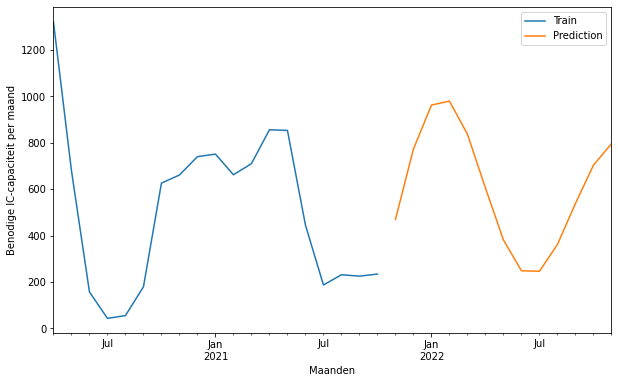

In [26]:
# Predict the future data.
final_model = ARIMA(Index_df_per_dag, order=(2,0,2)).fit()

prediction = final_model.predict(len(Index_df_per_dag), len(Index_df_per_dag) + 12)

Index_df_per_dag.plot(legend=True, label="Train", figsize=(10,6))
prediction.plot(legend=True, label="Prediction")
plt.xlabel("Maanden")
plt.ylabel("Benodige IC-capaciteit per maand")

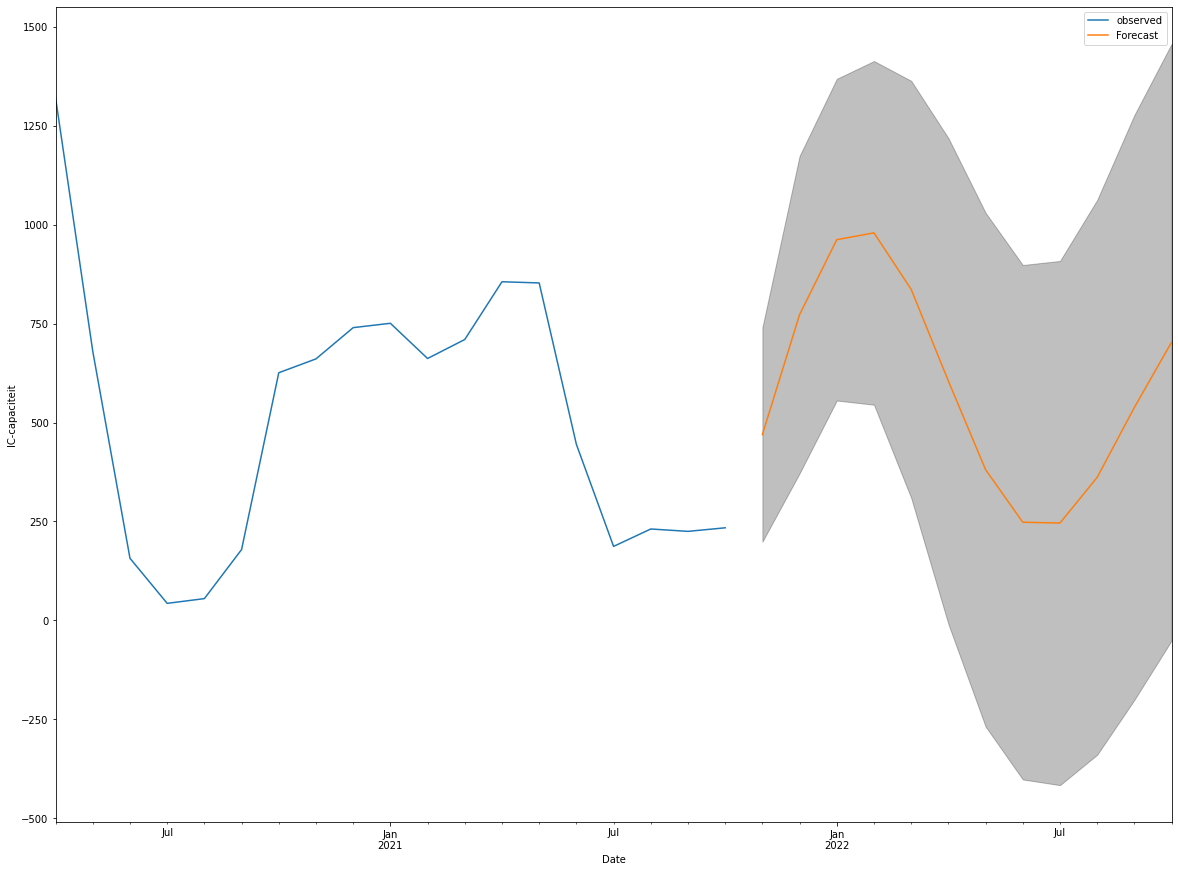

In [27]:
# Dezelfde plot als bovenstaande cel, met onzekerheid.
# Get forecast 12 steps ahead in future
pred_uc = final_model.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
#pred_ci = np.exp(pred_ci)

# Plot the model
ax = Index_df_per_dag.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capaciteit')

plt.legend()
plt.show()

In [28]:
# De negatieve waardes bij lower moeten weggewerkt worden.
pred_ci

,lower Aanwezig op IC verdacht of bewezen Corona,upper Aanwezig op IC verdacht of bewezen Corona
2021-11-01,198.859474,740.446824
2021-12-01,371.580918,1174.028726
2022-01-01,555.717242,1368.999053
2022-02-01,545.174243,1413.936673
2022-03-01,309.518531,1363.985314
2022-04-01,-9.289917,1219.322693
2022-05-01,-268.399142,1030.489437
2022-06-01,-402.201933,898.334985
2022-07-01,-416.516257,908.652256
2022-08-01,-339.781294,1062.790735


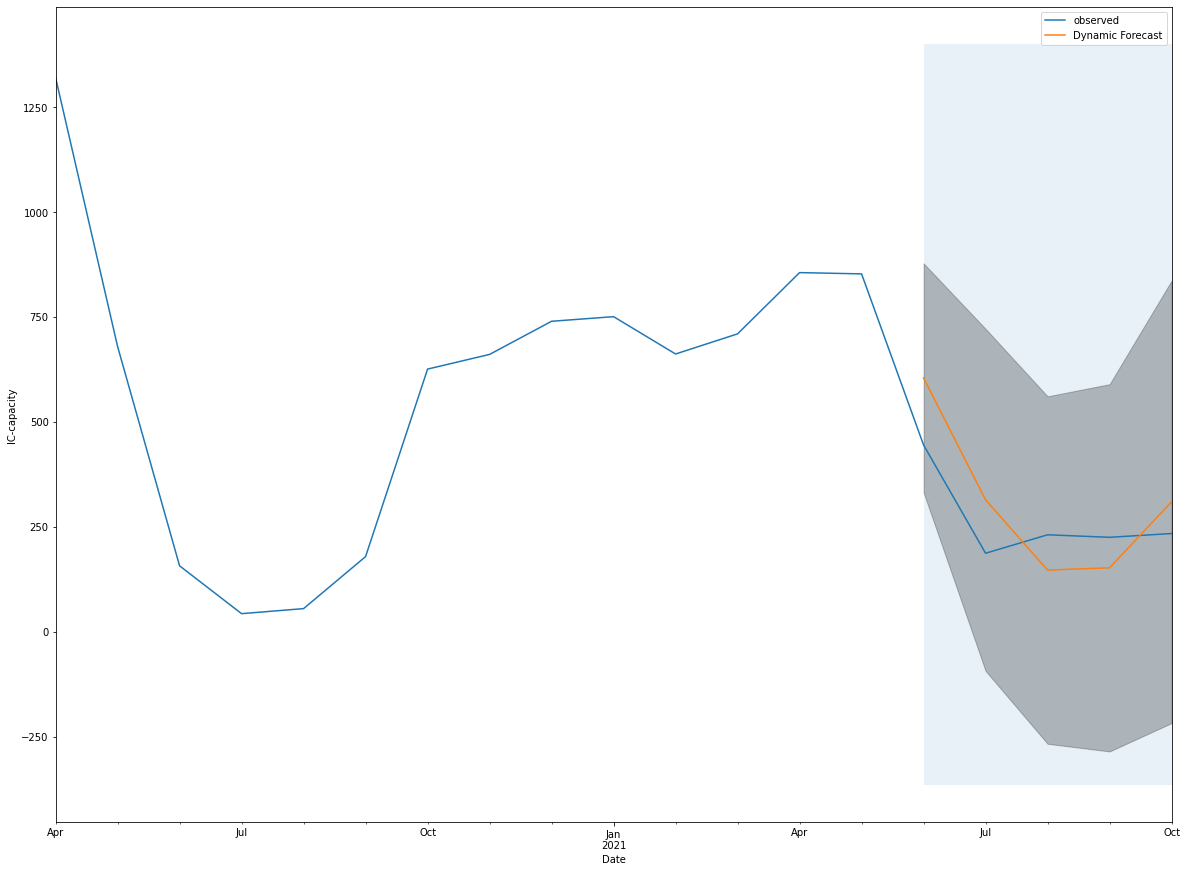

In [29]:
# Deze en onderstaande cel geven de forecasting over een aantal maanden weer.

pred_dynamic = final_model.get_prediction(start=pd.to_datetime('2021-06-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = Index_df_per_dag['2020':].plot(label='observed', figsize=(20,15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-06-01'), Index_df_per_dag.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')

plt.legend()
plt.show()

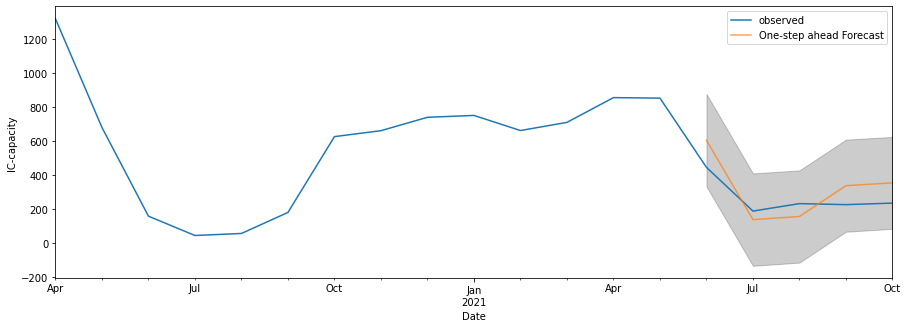

In [30]:
pred = final_model.get_prediction(start=pd.to_datetime('2021-06-01'), dynamic=False)
pred_ci = pred.conf_int()

# Plotting IC-capacity
ax = Index_df_per_dag['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15,5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
plt.legend()

plt.show()

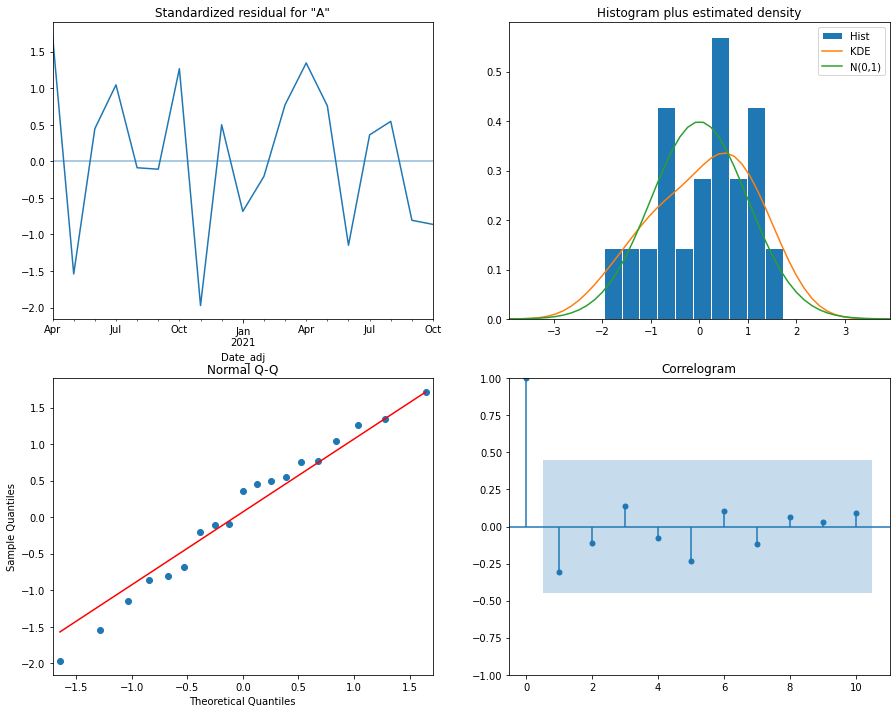

In [31]:
# Forecast testdata
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()

# Validate model with 2020 data

In [32]:
# Create Train and Test set
train_2020 = Index_df_per_dag[:9]
test_2021 = Index_df_per_dag[9:]
test_2021

Date_adj
2021-01-01    751
2021-02-01    662
2021-03-01    710
2021-04-01    856
2021-05-01    853
2021-06-01    445
2021-07-01    187
2021-08-01    231
2021-09-01    225
2021-10-01    234
Freq: MS, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

In [33]:
model_2020 = ARIMA(train, order=(2,0,2)).fit()

pred_2020 = model_2020.predict(start=len(train_2020), end=(len(Index_df_per_dag) -1))

Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

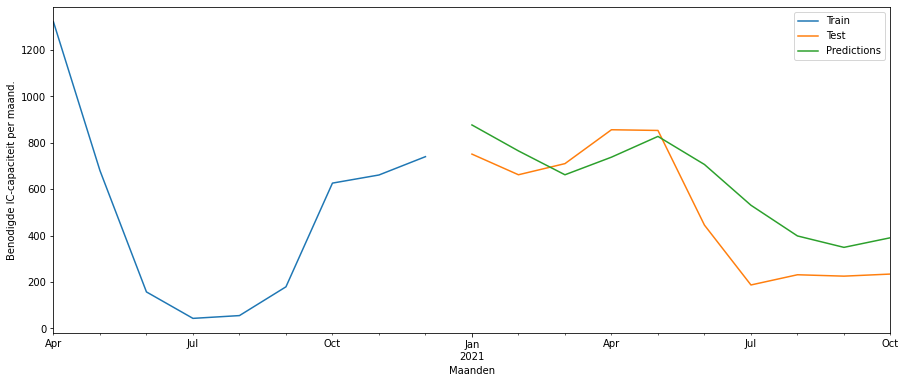

In [34]:
# Visualize predictions v.s. test values
train_2020.plot(legend=True, label="Train", figsize=(15,6))
test_2021.plot(legend=True, label="Test")
pred_2020.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

In [35]:
# Get the metrics of the model
forecast_accuracy(pred_2020, test_2021.values)

{'mean absolute percentage error': 0.4927677142482222,
 'mean error': 108.92441244705614,
 'mean absolute error': 147.31844069731972,
 'mean percentage error': 0.44558393661557333,
 'root mean squarred error': 172.4833786816344,
 'correlation': 0.8845498206154944,
 'minmax': 0.2707433669438596}